# SVM Classifier for non-linearly separable data

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.svm import SVC
from utils.plots import plot_decision_regions
from ipywidgets import interact
from sklearn.datasets import make_moons
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
rcParams['figure.figsize'] = (5,3)

##  Let's build our "XOR" dataset

<img src="https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/05-Model-Tuning/non-linear-dataset.png" width=450>

In [2]:
print(np.logical_xor(True, True))
print(np.logical_xor(True, False))
print(np.logical_xor(False, False))

False
True
False


In [3]:
np.logical_xor([True, True, False], [True, False, False])

array([False,  True, False])

In [4]:
# Number of datapoints
n = 500
noise = 0.2

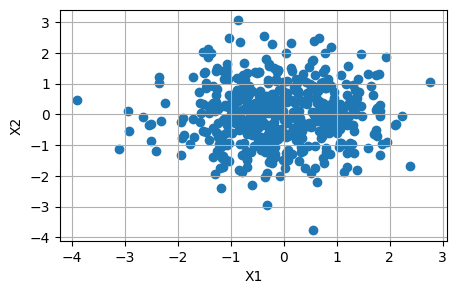

In [5]:
rng = np.random.default_rng(0)
X = rng.standard_normal((n, 2))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show();

In [6]:
x1 = X[:, 0]
x2 = X[:, 1]

In [7]:
# Then, build our binary class y
# where y=1 if and only if (X1 > ε xor X2 > ε)
# epsilon ε not exactly zero to simulate "noise"
epsilon = noise * rng.standard_normal(n)

y_bool = np.logical_xor(
    x1 > epsilon,
    x2 > epsilon
)
y = np.where(y_bool, 1, 0)

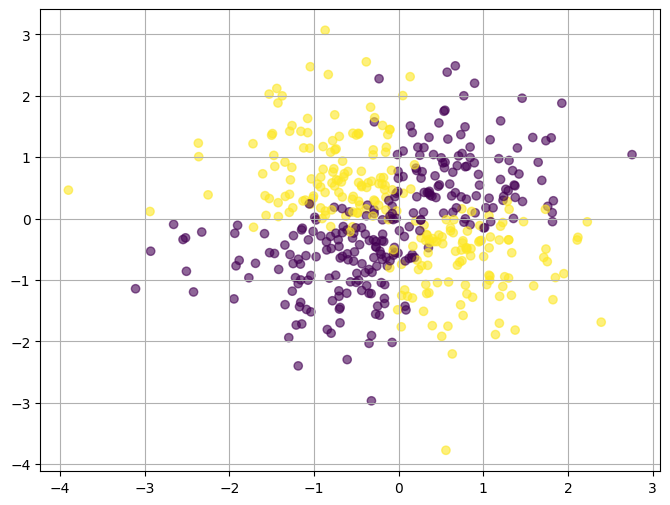

In [8]:
# XOR quadrant!
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6)
plt.grid(True)
plt.show();

##  Linear SVM

In [9]:
svc = SVC(kernel='linear', C=1)
svc.fit(X, y)

SVC(C=1, kernel='linear')

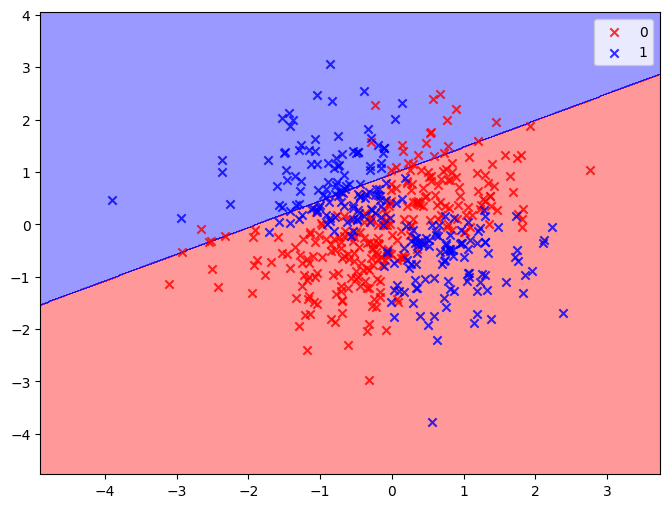

In [10]:
plt.figure(figsize=(8, 6))
plot_decision_regions(X, y, classifier=svc)
plt.show();

In [11]:
linear_svm_score = svc.score(X, y)

## 3. Kernel SVM 🔥

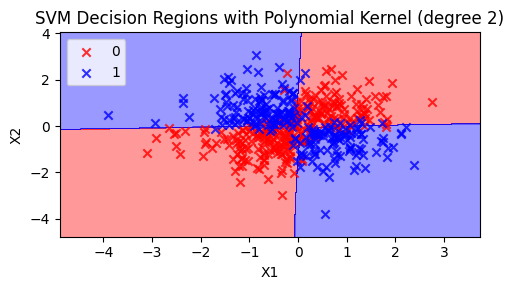

In [12]:
poly_svm = SVC(kernel='poly', degree=2, C=100)
# Fit the model
poly_svm.fit(X, y)
# Plot the decision regions
plot_decision_regions(X, y, classifier=poly_svm)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('SVM Decision Regions with Polynomial Kernel (degree 2)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

❓ Given that you know how this XOR dataset has been engineered, which adjectives best describe your svm's performance?

In [13]:
a = 'is underfitting'
b = 'captures all reducible error'
c = 'has too high variance'
d = 'has only irreducible errors left'

poly_svm_performance = [b, d]

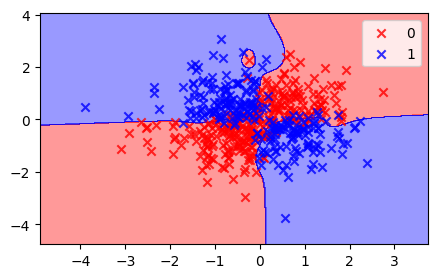

In [14]:
degree = 6

equivalent_polynomial_model = make_pipeline(
    (PolynomialFeatures(degree=degree)),  
    (SVC(kernel='linear', C=100))  
)
equivalent_polynomial_model.fit(X, y)
plot_decision_regions(X, y, classifier=equivalent_polynomial_model)

### Moons dataset

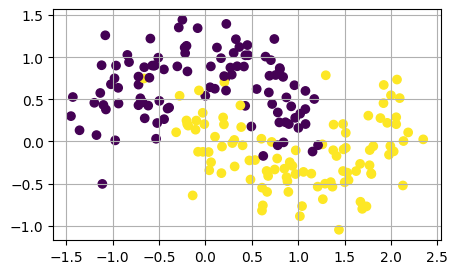

In [15]:
n=200
X,y = make_moons(n_samples=n, noise=0.25, random_state=0)
plt.grid(True)
plt.scatter(X[:,0], X[:,1], c=y);
plt.show();

In [16]:
@interact(C=[1, 10, 1000, 10000, 100000], degree=[1,2,3,4,5,6,7,8,9], coef0=[0,0.5,1,2,5,10,100])
def svc(C, degree, coef0):
    svm = SVC(kernel='poly', C=C, coef0=coef0, degree=degree)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

interactive(children=(Dropdown(description='C', options=(1, 10, 1000, 10000, 100000), value=1), Dropdown(descr…

## 3.3 RBF - Radial Basis Function Kernel (aka gaussian)

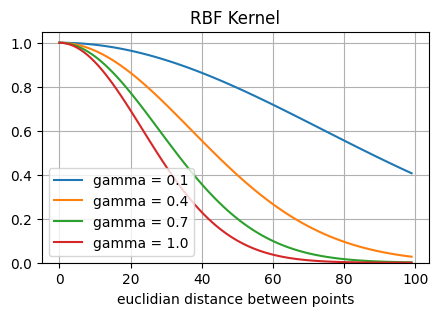

In [17]:
for gamma in np.linspace(0.1, 1, 4):
    plt.plot(np.exp(-gamma*np.linspace(0, 3, 100)**2),
             label=f'gamma = {gamma}')
plt.ylim(0,)
plt.title('RBF Kernel')
plt.xlabel('euclidian distance between points')
plt.grid(True)
plt.legend();

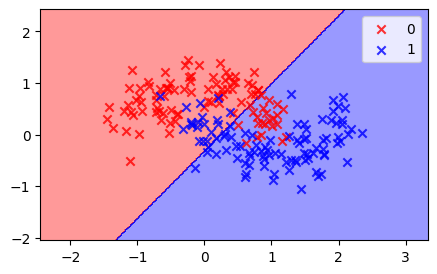

In [18]:
svm_rbf_low_var = SVC(kernel='rbf', gamma=0.01, C=0.1)
svm_rbf_low_var.fit(X, y)

# Plot the decision regions
plot_decision_regions(X, y, classifier=svm_rbf_low_var)
plt.show()

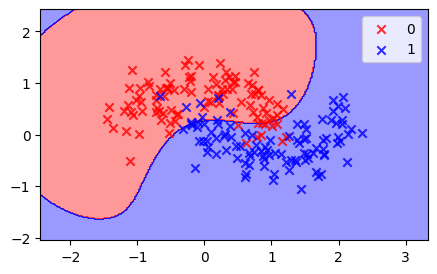

In [19]:
svm_rbf = SVC(kernel='rbf', gamma=1, C=0.1)
svm_rbf.fit(X, y)

# Plot the decision regions
plot_decision_regions(X, y, classifier=svm_rbf)
plt.show()

In [20]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(C=[0.1, 1, 10, 100, 1000, 10000], gamma = [0.001, 0.01, 0.1, 1, 10])
def svc(C=1, gamma=1):
    svm = SVC(kernel='rbf', gamma=gamma, C=C)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

interactive(children=(Dropdown(description='C', index=1, options=(0.1, 1, 10, 100, 1000, 10000), value=1), Dro…

In [21]:
best_c = 10
best_gamma = 0.1

## 3.4 Sigmoid kernel

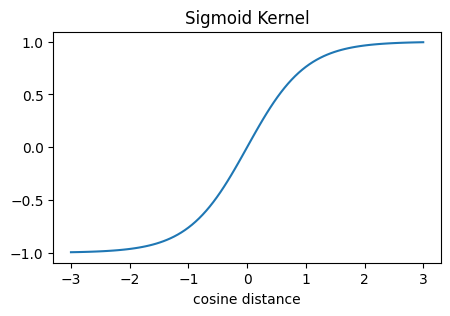

In [22]:
# The "tangent hyperbolic" function resembles sigmoid but can take negative values
x = np.linspace(-3,3,100)
plt.plot(x, np.tanh(x))
plt.xlabel('cosine distance'); plt.title('Sigmoid Kernel');

In [23]:
@interact(C=[0.1, 1, 10, 100, 1000, 10000], gamma = [0.001, 0.01, 0.1, 1, 10], coef0=0.)
def svc(C=1000, gamma=0.1, coef0=0):
    svm = SVC(kernel='sigmoid', gamma=gamma, C=C, coef0=coef0)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

interactive(children=(Dropdown(description='C', index=4, options=(0.1, 1, 10, 100, 1000, 10000), value=1000), …

## 4. Grid Search the best kernel

In [24]:
# Define the parameter ranges
param_distributions = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

# Initialize the model
svc = SVC()

# Initialize the random search
random_search = RandomizedSearchCV(
    svc, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=5, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X, y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [0.001, 0.01, 0.1, 1, 10],
                                        'kernel': ['rbf', 'linear']},
                   random_state=42, verbose=2)

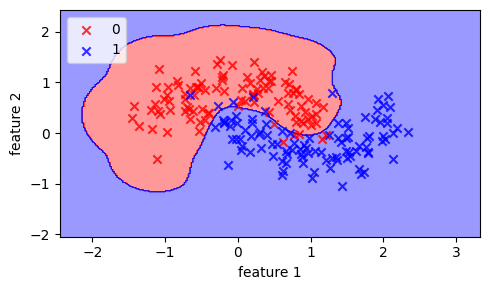

In [25]:
# Assuming `best_model` is your optimized model from the RandomizedSearchCV
best_model = random_search.best_estimator_

# Fit the best model with the data
best_model.fit(X, y)

# Use the `plot_decision_regions` function to visualize the decision boundaries
plot_decision_regions(X, y, classifier=best_model)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [26]:
from sklearn.model_selection import cross_val_score

# 5-fold cross validation
scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Mean cross-validation accuracy
best_svm_cv_accuracy = np.mean(scores)


## 5. Generalization

In [27]:
best_svm = best_model.fit(X, y)

In [28]:
# Generate a half-moon test_set of size n_test
n_test = 100
X_test, y_test = make_moons(n_samples=n, noise=0.2, random_state=1)

X_full = np.vstack((X, X_test))
y_full = np.append(y, values = y_test)
test_idx = np.arange(n,n+n_test)

Number of misclassified test samples: 7


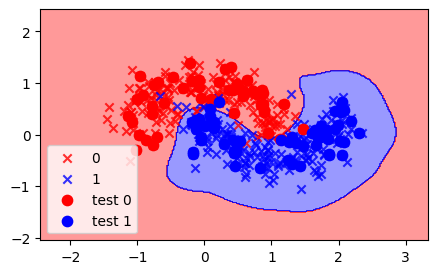

In [30]:
# Fit the model on the full data
best_svm.fit(X_full, y_full)

# Use the model to predict the test set
y_test_pred = best_svm.predict(X_test)

# Count the number of misclassified test samples
n_misclassified = np.sum(y_test_pred != y_test)

print(f'Number of misclassified test samples: {n_misclassified}')

# Plot decision regions
plot_decision_regions(X_full, y_full, classifier=best_svm, test_idx=test_idx)
plt.show()